
[Hold-out SARIMAX] Total guest nights | order=(0,0,1), seasonal=(0,1,1,12), trend='n' | AIC=80.788

[Hold-out SARIMAX] International guest nights | order=(0,0,1), seasonal=(0,1,1,12), trend='n' | AIC=61.463

[Hold-out SARIMAX] Domestic guest nights | order=(0,0,1), seasonal=(0,1,1,12), trend='n' | AIC=87.803

[Hold-out] 2024-07-31 → 2025-06-30

Total guest nights
  RMSE : 2,208,904.267
  MAE  : 1,811,461.220
  MAPE : 14.916%
  sMAPE: 13.435%

International guest nights
  RMSE : 4,239,159.258
  MAE  : 3,698,340.850
  MAPE : 105.088%
  sMAPE: 59.376%

Domestic guest nights
  RMSE : 837,281.533
  MAE  : 668,448.553
  MAPE : 7.750%
  sMAPE: 7.422%

[Full-fit SARIMAX] Total guest nights | order=(1, 1, 1), seasonal=(1, 1, 1, 12) | AIC=1127.199

[Full-fit SARIMAX] International guest nights | order=(1, 1, 1), seasonal=(1, 1, 1, 12) | AIC=1351.528

[Full-fit SARIMAX] Domestic guest nights | order=(1, 1, 1), seasonal=(1, 1, 1, 12) | AIC=1339.043

[SARIMAX] Combined forecast window

Forecast re

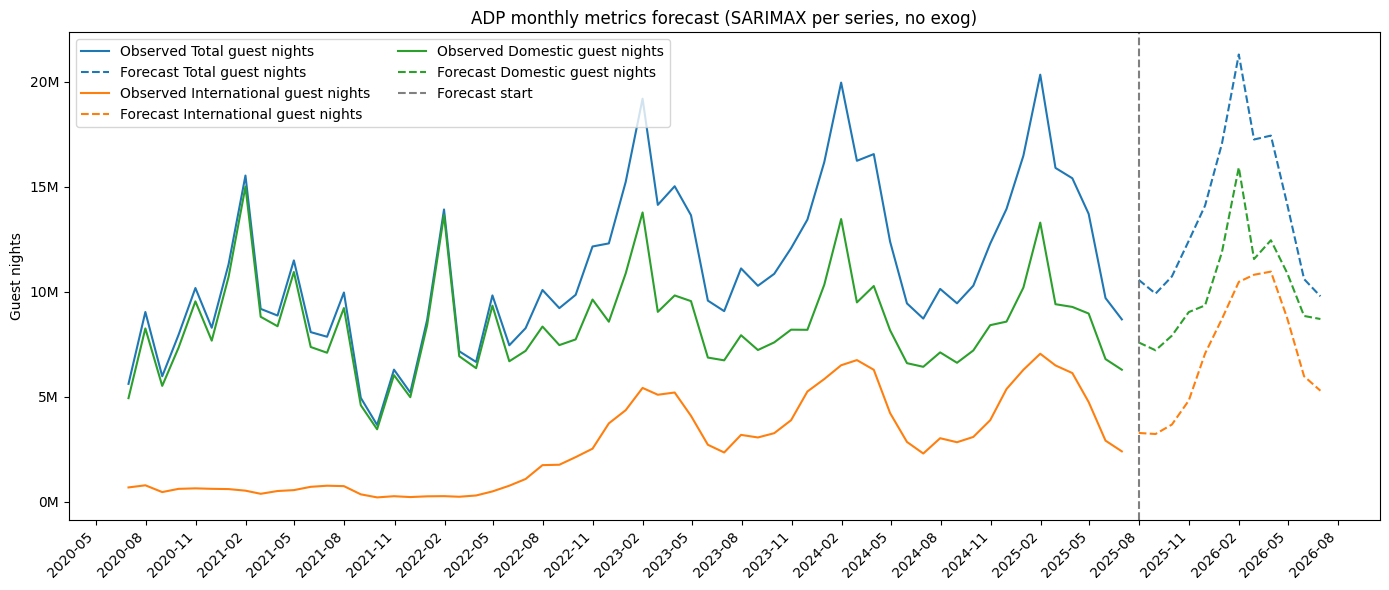

In [3]:
# model_03_sarimax_adp.py
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick

from pandas.tseries.offsets import MonthEnd
from statsmodels.tsa.statespace.sarimax import SARIMAX

# ----------------------- Config -----------------------
ADP_CSV = "../datasets/ADP_All_Measures.csv"

HORIZON = 12
HOLDOUT_STEPS = 12

SERIES = [
    "Total guest nights",
    "International guest nights",
    "Domestic guest nights",
]

# Default SARIMA orders per series (nonseasonal + seasonal(.,.,.,12))
SARIMA_ORDERS = {
    "Total guest nights": (1, 1, 1),
    "International guest nights": (1, 1, 1),
    "Domestic guest nights": (1, 1, 1),
}
SARIMA_SEASONAL_ORDERS = {
    "Total guest nights": (1, 1, 1, 12),
    "International guest nights": (1, 1, 1, 12),
    "Domestic guest nights": (1, 1, 1, 12),
}

# ----------------------- Helpers -----------------------
def full_month_range(idx):
    start = pd.to_datetime(idx.min()) + MonthEnd(0)
    end = pd.to_datetime(idx.max()) + MonthEnd(0)
    return pd.date_range(start=start, end=end, freq="ME")

def configure_ax(ax):
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

def print_banner(s):
    bar = "=" * len(s)
    print(f"\n{bar}\n{s}\n{bar}")

# ----------------------- Load & Aggregate ADP -----------------------
def load_adp_national(adp_csv: str) -> pd.DataFrame:
    adp = pd.read_csv(adp_csv)
    adp["Month"] = pd.to_datetime(adp["Month"], format="%Y-%m-%d", errors="coerce")
    adp["Date"] = adp["Month"] + MonthEnd(0)

    if "Total guest nights" not in adp.columns:
        if {"Domestic guest nights", "International guest nights"}.issubset(adp.columns):
            adp["Total guest nights"] = (
                adp["Domestic guest nights"] + adp["International guest nights"]
            )
        else:
            raise ValueError("Missing both 'Total guest nights' and components to construct it.")

    g = adp.groupby("Date")[SERIES].sum(min_count=1).sort_index()
    idx = full_month_range(g.index)
    g = g.reindex(idx).ffill().bfill()
    return g

# ----------------------- Transformations -----------------------
def forward_transform(df: pd.DataFrame):
    """
    Log1p + standardize (mean/sd) so SARIMAX works on roughly stationary scale.
    We’ll forecast on z_std and invert via expm1 after destandardizing.
    """
    z = np.log1p(df.clip(lower=0))
    mu, sd = z.mean(), z.std(ddof=0).replace(0, 1.0)
    z_std = (z - mu) / sd
    return z_std, {"mu": mu, "sd": sd}

def inverse_transform(z_std: pd.DataFrame, meta: dict):
    z = z_std * meta["sd"] + meta["mu"]
    return np.expm1(z).clip(lower=0)

# ----------------------- Metrics -----------------------
def _rmse(a, f):
    return float(np.sqrt(np.mean((np.asarray(a, float) - np.asarray(f, float)) ** 2)))

def _mae(a, f):
    return float(np.mean(np.abs(np.asarray(a, float) - np.asarray(f, float))))

def _mape(a, f):
    a, f = np.asarray(a, float), np.asarray(f, float)
    mask = a != 0
    return float(np.mean(np.abs((a[mask] - f[mask]) / a[mask])) * 100) if mask.any() else np.nan

def _smape(a, f):
    a, f = np.asarray(a, float), np.asarray(f, float)
    denom = np.abs(a) + np.abs(f)
    mask = denom != 0
    return float(np.mean(2 * np.abs(a[mask] - f[mask]) / denom[mask]) * 100) if mask.any() else np.nan

def print_metrics_block(title, actual: pd.Series, forecast: pd.Series):
    print_banner(title)
    print(f"  RMSE : {_rmse(actual, forecast):,.3f}")
    print(f"  MAE  : {_mae(actual, forecast):,.3f}")
    print(f"  MAPE : {_mape(actual, forecast):.3f}%")
    print(f"  sMAPE: {_smape(actual, forecast):.3f}%")

# ----------------------- Per-series SARIMAX fit/forecast -----------------------
def _fit_sarimax_1d(y: pd.Series, order, seasonal_order):
    """
    Fit SARIMAX (no exog) on a single transformed series (z_std).
    Robust fallback: try a small set of alternative (order, seasonal_order) pairs.
    """
    try_specs = [
        (order, seasonal_order),
        ((1, 1, 0), seasonal_order),
        ((0, 1, 1), seasonal_order),
        ((0, 1, 0), (0, 1, 0, 12)),
    ]
    last_err = None
    for ord_, seas_ in try_specs:
        try:
            mod = SARIMAX(
                endog=y,
                order=ord_,
                seasonal_order=seas_,
                trend="c",
                enforce_stationarity=False,
                enforce_invertibility=False,
            )
            res = mod.fit(disp=False)
            return res, ord_, seas_
        except Exception as e:
            last_err = e
            continue

def _forecast_with_ci(res, steps, start_next_dtindex):
    """
    Get forecast mean and CI (on transformed scale) and align to a given monthly index.
    """
    fc = res.get_forecast(steps=steps)
    mu = fc.predicted_mean.copy()
    ci = fc.conf_int().copy()
    idx = pd.date_range(start=start_next_dtindex, periods=steps, freq="ME")
    mu.index = idx
    ci.index = idx
    return mu, ci

# ----------------------- Hold-out evaluation -----------------------
def evaluate_holdout_sarimax(
    g: pd.DataFrame,
    holdout_steps: int = HOLDOUT_STEPS,
):
    if len(g) < (holdout_steps + 36):
        holdout_steps = max(6, len(g) - 36)
    if holdout_steps <= 0:
        return

    train_g, test_g = g.iloc[:-holdout_steps], g.iloc[-holdout_steps:]
    z_train, meta_train = forward_transform(train_g)

    mu_test_std = pd.DataFrame(index=test_g.index, columns=SERIES, dtype="float64")
    ci_lower_std = pd.DataFrame(index=test_g.index, columns=SERIES, dtype="float64")
    ci_upper_std = pd.DataFrame(index=test_g.index, columns=SERIES, dtype="float64")

    start_next = train_g.index[-1] + MonthEnd(1)

    for col in SERIES:
        zcol = z_train[col].dropna()
        mod = SARIMAX(
            endog=zcol,
            order=(0,0,1),
            seasonal_order=(0,1,1,12),
            trend="c",     
            enforce_stationarity=True,
            enforce_invertibility=True,
        )
        res = mod.fit(disp=False)
        mu_col, ci_col = _forecast_with_ci(res, holdout_steps, start_next)

        mu_test_std[col]  = mu_col
        ci_lower_std[col] = ci_col.iloc[:, 0]
        ci_upper_std[col] = ci_col.iloc[:, 1]

        print_banner(
            f"[Hold-out SARIMAX] {col} | order=(0,0,1), seasonal=(0,1,1,12), trend='n' "
            f"| AIC={res.aic:.3f}"
        )


    # Inverse transform means and CIs to level space
    fc_test_levels = inverse_transform(mu_test_std, meta_train)

    # Metrics
    print_banner(f"[Hold-out] {test_g.index[0].date()} → {test_g.index[-1].date()}")
    for col in SERIES:
        print_metrics_block(col, test_g[col], fc_test_levels[col])

# ----------------------- Full-fit & future forecast -----------------------
def fit_full_and_forecast_sarimax(
    g: pd.DataFrame,
    horizon: int = HORIZON,
    sarima_orders: dict = None,
    sarima_seasonal_orders: dict = None,
):
    orders = sarima_orders or SARIMA_ORDERS
    seas_orders = sarima_seasonal_orders or SARIMA_SEASONAL_ORDERS

    z_full, meta_full = forward_transform(g)

    mu_future_std = pd.DataFrame(
        index=pd.date_range(g.index[-1] + MonthEnd(1), periods=horizon, freq="ME"),
        columns=SERIES,
        dtype="float64",
    )
    ci_lower_std = mu_future_std.copy()
    ci_upper_std = mu_future_std.copy()

    for col in SERIES:
        res, used_order, used_seas = _fit_sarimax_1d(
            z_full[col].dropna(),
            orders.get(col, (1, 1, 1)),
            seas_orders.get(col, (1, 1, 1, 12)),
        )
        start_next = g.index[-1] + MonthEnd(1)
        mu_col, ci_col = _forecast_with_ci(res, horizon, start_next)

        mu_future_std[col] = mu_col
        ci_lower_std[col] = ci_col.iloc[:, 0]
        ci_upper_std[col] = ci_col.iloc[:, 1]

        print_banner(f"[Full-fit SARIMAX] {col} | order={used_order}, seasonal={used_seas} | AIC={res.aic:.3f}")

    # Back-transform to levels
    fc_levels = inverse_transform(mu_future_std, meta_full)
    fc_lo     = inverse_transform(ci_lower_std, meta_full)
    fc_hi     = inverse_transform(ci_upper_std, meta_full)

    return fc_levels, fc_lo, fc_hi

# ----------------------- Main -----------------------
def main():
    g = load_adp_national(ADP_CSV)

    # Holdout performance (OOS metrics)
    evaluate_holdout_sarimax(
        g,
        holdout_steps=HOLDOUT_STEPS,
    )

    # Fit on full data and forecast horizon
    fc_levels, fc_lo, fc_hi = fit_full_and_forecast_sarimax(
        g,
        horizon=HORIZON,
        sarima_orders=SARIMA_ORDERS,
        sarima_seasonal_orders=SARIMA_SEASONAL_ORDERS,
    )

    start_fc = fc_levels.index[0]
    observed = g.copy()

    print_banner("[SARIMAX] Combined forecast window")

    # ---------------- Save forecast results ----------------
    # One wide CSV: Forecast/Lower/Upper for each series
    out = pd.DataFrame(index=fc_levels.index)
    for col in SERIES:
        out[f"Forecast {col}"] = fc_levels[col]
        out[f"Lower_CI {col}"] = fc_lo[col]
        out[f"Upper_CI {col}"] = fc_hi[col]

    out.index.name = "Date"
    out_csv = "../output/Model_02_SARIMAX_ADP.csv"
    out.to_csv(out_csv)
    print(f"\nForecast results saved to: {out_csv}")

    # ---------------- Combined plot ----------------
    plt.figure(figsize=(14, 6))
    colors = {
        "Total guest nights": "#1f77b4",
        "International guest nights": "#ff7f0e",
        "Domestic guest nights": "#2ca02c",
    }
    for col in SERIES:
        # Observed
        plt.plot(observed.index, observed[col], label=f"Observed {col}", color=colors[col])
        # Forecast
        plt.plot(fc_levels.index, fc_levels[col], linestyle="--", label=f"Forecast {col}", color=colors[col])
        # Simple CI band per series (can overlap visually)
        plt.fill_between(fc_levels.index, fc_lo[col], fc_hi[col], color=colors[col], alpha=0.12)

    plt.axvline(start_fc, color="gray", linestyle="--", label="Forecast start")
    plt.title("ADP monthly metrics forecast (SARIMAX per series, no exog)")
    plt.ylabel("Guest nights")
    plt.legend(loc="upper left", ncol=2, frameon=True)
    plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x*1e-6:,.0f}M"))
    configure_ax(plt.gca())
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()
